# Movie Recommendation System

The idea behind the project is placing a user in a group where he shares the same tastes in movies with others. This will be achieved using the genres of the movies.

The dataset used for this project can be found on kaggle:

- https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?select=movies_metadata.csv



## Import Libraries

In [6]:
import pandas as pd                
import matplotlib.pyplot as plt    
import seaborn as sns              
import numpy as np        

from copy import deepcopy                            

from sklearn.cluster import KMeans                   
from sklearn.metrics import silhouette_samples       
from sklearn.metrics import silhouette_score         
from sklearn.metrics import calinski_harabasz_score  
from sklearn.metrics import confusion_matrix        

## Data loading

In [7]:
movies_df = pd.read_csv('movies_metadata.csv')
ratings_df = pd.read_csv('ratings.csv')

C:\Users\Juan Pablo\AppData\Local\Temp\ipykernel_30204\3187435724.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies_df = pd.read_csv('movies_metadata.csv')


In [8]:
print(movies_df.head())
print(movies_df.info())
print(movies_df.shape)

   adult                              belongs_to_collection    budget  \
0  False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
1  False                                                NaN  65000000   
2  False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0   
3  False                                                NaN  16000000   
4  False  {'id': 96871, 'name': 'Father of the Bride Col...         0   

                                              genres  \
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
4                     [{'id': 35, 'name': 'Comedy'}]   

                               homepage     id    imdb_id original_language  \
0  http://toystory.disney.com/toy-story    862  tt0114709                en   
1                                   NaN   8844  tt0113497         

In [9]:
print(ratings_df.head())
print(ratings_df.info())
print(ratings_df.shape)

   userId  movieId  rating   timestamp
0       1      110     1.0  1425941529
1       1      147     4.5  1425942435
2       1      858     5.0  1425941523
3       1     1221     5.0  1425941546
4       1     1246     5.0  1425941556
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26024289 entries, 0 to 26024288
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 794.2 MB
None
(26024289, 4)


## Exploration

In [10]:
#Cleaning genres 
movies_df['genres'] = movies_df['genres'].str.strip('[]').str.replace('{','').str.replace('}','').str.replace('id','').str.replace('name','').str.replace("'",'').str.replace(':','').str.replace(",", "").str.replace(" ", "")
movies_df['genres'].replace(r'[0-9]','',regex=True, inplace = True)
movies_df['genres'].replace(r'([a-z](?=[A-Z])|[A-Z](?=[A-Z][a-z]))', r'\1 ',regex=True, inplace = True)
movies_df['genres'].replace(' ',',',regex=True, inplace = True)
movies_df['genres']

C:\Users\Juan Pablo\AppData\Local\Temp\ipykernel_30204\1709206939.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  movies_df['genres'] = movies_df['genres'].str.strip('[]').str.replace('{','').str.replace('}','').str.replace('id','').str.replace('name','').str.replace("'",'').str.replace(':','').str.replace(",", "").str.replace(" ", "")


0         Animation,Comedy,Family
1        Adventure,Fantasy,Family
2                  Romance,Comedy
3            Comedy,Drama,Romance
4                          Comedy
                   ...           
45461                Drama,Family
45462                       Drama
45463       Action,Drama,Thriller
45464                            
45465                            
Name: genres, Length: 45466, dtype: object

In [11]:
#Only english movies with genres
movies_df_en = movies_df[movies_df['original_language'] == "en"]
print(movies_df_en.shape)
movies_df_filtered = movies_df_en[movies_df['genres'] != ""]
print(movies_df_filtered.shape)

(32269, 24)
(30584, 24)


C:\Users\Juan Pablo\AppData\Local\Temp\ipykernel_30204\3493247537.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_df_filtered = movies_df_en[movies_df['genres'] != ""]


In [12]:
movies = movies_df_filtered[['id','original_title', 'genres']]
movies = movies.rename(columns={"id": "movieId"})
movies['movieId'] = movies['movieId'].astype(str).astype(int)
movies

,movieId,original_title,genres
0,862,Toy Story,"Animation,Comedy,Family"
1,8844,Jumanji,"Adventure,Fantasy,Family"
2,15602,Grumpier Old Men,"Romance,Comedy"
3,31357,Waiting to Exhale,"Comedy,Drama,Romance"
4,11862,Father of the Bride Part II,Comedy
...,...,...,...
45457,390959,Shadow of the Blair Witch,"Mystery,Horror"
45458,289923,The Burkittsville 7,Horror
45459,222848,Caged Heat 3000,"Science,Fiction"
45460,30840,Robin Hood,"Drama,Action,Romance"


In [13]:
movies_graph = deepcopy(movies)
movies_graph["genres"] = movies_graph["genres"].str.split(',')
movies_graph

,movieId,original_title,genres
0,862,Toy Story,"[Animation, Comedy, Family]"
1,8844,Jumanji,"[Adventure, Fantasy, Family]"
2,15602,Grumpier Old Men,"[Romance, Comedy]"
3,31357,Waiting to Exhale,"[Comedy, Drama, Romance]"
4,11862,Father of the Bride Part II,[Comedy]
...,...,...,...
45457,390959,Shadow of the Blair Witch,"[Mystery, Horror]"
45458,289923,The Burkittsville 7,[Horror]
45459,222848,Caged Heat 3000,"[Science, Fiction]"
45460,30840,Robin Hood,"[Drama, Action, Romance]"


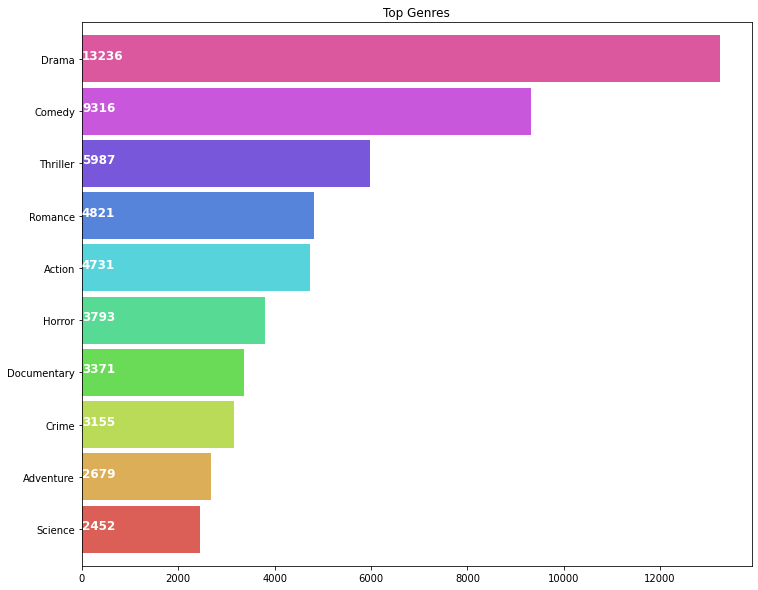

In [14]:
plt.subplots(figsize=(12,10))
list1 = []
for i in movies_graph['genres']:
    list1.extend(i)
ax = pd.Series(list1).value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('hls',10))
for i, v in enumerate(pd.Series(list1).value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=12,color='white',weight='bold')
plt.title('Top Genres')
plt.show()

The top 5 genres are:

1.   Drama
2.   Comedy
3.   Thriller
4.   Romance
5.   Action

We will be using these to generate our clusters based on users average

In [15]:
def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:        
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
        
        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)
        
    genre_ratings.columns = column_names
    return genre_ratings

In [16]:
genre_ratings = get_genre_ratings(ratings_df, movies,
                                  ['Drama', 'Comedy', 'Thriller', 'Romance', 'Action'],
                                  ['avg_drama_rating', 'avg_comedy_rating', 'avg_thriller_rating', 'avg_romance_rating','avg_action_rating'])
print( "Number of records: ", len(genre_ratings))
print(genre_ratings.info())
genre_ratings.head()

Number of records:  261237
<class 'pandas.core.frame.DataFrame'>
Index: 261237 entries, 1 to 270039
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   avg_drama_rating     250352 non-null  float64
 1   avg_comedy_rating    230941 non-null  float64
 2   avg_thriller_rating  235983 non-null  float64
 3   avg_romance_rating   200488 non-null  float64
 4   avg_action_rating    224521 non-null  float64
dtypes: float64(5)
memory usage: 12.0+ MB
None


,avg_drama_rating,avg_comedy_rating,avg_thriller_rating,avg_romance_rating,avg_action_rating
1,4.62,4.25,NaN,4.5,3.50
2,2.50,2.80,4.00,4.0,3.67
3,3.50,3.25,2.50,3.5,3.00
4,4.00,2.80,3.67,3.5,3.67
5,4.40,5.00,3.25,5.0,2.67


In [17]:
#Remove less than 3 and  null values
genre_ratings = genre_ratings[genre_ratings>=2.0]
genre_ratings = genre_ratings.dropna()
print(genre_ratings.info())

<class 'pandas.core.frame.DataFrame'>
Index: 161812 entries, 2 to 270896
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   avg_drama_rating     161812 non-null  float64
 1   avg_comedy_rating    161812 non-null  float64
 2   avg_thriller_rating  161812 non-null  float64
 3   avg_romance_rating   161812 non-null  float64
 4   avg_action_rating    161812 non-null  float64
dtypes: float64(5)
memory usage: 7.4+ MB
None


## Model Development

In [18]:
#Model method 1
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
# HYPERPARÁMETROS DEL MODELO
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
kmin              = 1           #Límite inferior para explorar el número de grupos.
kmax              = 10          #Límite superior para explorar el número de grupos.
init              ='k-means++'  #Se define el método de inicialización. Otra opción válida es 'random'.
n_init            = 10          #Número de inicializaciones aleatorias. Al final scikit learn escoge aquel con la menor inercia 
                                  #(i.e.: suma de cuadrados de distancias de cada punto a su centroide respectivo dentro de cada grupo, para todos los puntos). 
                                  #https://scikit-learn.org/stable/modules/clustering.html
max_iter          = 300         #Número MÁXIMO de iteraciones para una sola ejecución.
random_seed       = 42          #Semilla aleatoria. Permite obtener los mismos resultados en cada ejecución.

def elbow_calinski(df_x_train, kmin, kmax, init, n_init, max_iter, random_seed):
 

  #-------------------------------------------------------------------------------
  #-------------------------------------------------------------------------------
  # CONSTRUCCIÓN Y EVALUACIÓN DE MÚLTIPLES MODELOS VARIANDO K
  #-------------------------------------------------------------------------------
  #-------------------------------------------------------------------------------

  k_list = list(np.arange(kmin,kmax+1,1))  #Lista con los valores de k que se van a explorar [kmin,kmax].
  inertia_list                 = [] #Lista vacía. Va a almacenar los valores de inercia para cada valor de k. 
                                    #La inercia = sumatoria( ( x_i-centroide(x_i) )^2 ). 
                                    #La inercia = sumatoria de los cuadrados de las distancias de las observaciones al centroide más cercano.
  silhouette_score_list        = [] #Lista vacía. Va a almacenar los valores de silueta promedio para todas las observaciones para cada valor de k.  
  calinski_harabasz_score_list = [] #Lista vacía. Va a almacenar los valores del índice Calinski Harabasz para cada valor de k.  

  for k in k_list: #Explore los valores de k en la lista.
    #Se instancia el objeto para utilizar el agrupamiento con k-means.
    #Para ver todas los opciones del constructor, consulte: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
    #Nota: el algoritmo de k-means disponible en scikit-learn funciona únicamente con la distancia euclidiana.
    #Si usted requiere aplicar k-means con otras métricas de distancia, puede consultar la librería PyClustering: https://github.com/annoviko/pyclustering
    model1 = KMeans(n_clusters=k,        #Se define el número de grupos.
                    init=init,           #Se define el método de inicialización. 
                    n_init=n_init,       #Número de inicializaciones aleatorias. Al final se escoge aquel con la menor inercia. 
                    max_iter=max_iter,   #Número MÁXIMO de iteraciones para una sola ejecución.
                    random_state=random_seed)

    #Se hace el ajuste (i.e.: encontramos los centroides).
    model1.fit(df_x_train)

    #Agregamos a la lista el valor de inercia que se obtiene para el número actual de grupos.
    inertia_list.append(model1.inertia_)

    if k==1: #En caso que se esté evaluando el caso cuando el número de grupos es 1...
      silhouette_score_list.append(np.nan)         #Esto sirve como recordatorio que no se puede calcular este valor.
      calinski_harabasz_score_list.append(np.nan)  #Esto sirve como recordatorio que no se puede calcular este índice.
    else:
      #Agregamos a la lista el valor de la silueta promedio para todas las observaciones.
      silhouette_score_list.append(silhouette_score(df_x_train.values, model1.labels_))
      calinski_harabasz_score_list.append(calinski_harabasz_score(df_x_train.values, model1.labels_))  #model1.labels_ es un arreglo numpy de orden 1 (i.e. no es vector fila, no es vector columna...)

  #-------------------------------------------------------------------------------
  #-------------------------------------------------------------------------------
  # 1. MÉTODO DEL CODO
  #-------------------------------------------------------------------------------
  #-------------------------------------------------------------------------------
  #Ahora generamos la gráfica requerida para aplicar el método del codo.
  plt.figure(figsize=(10,5))  #Tamaño de la figura (ancho, alto).
  plt.plot(k_list, inertia_list,color='blue',marker='o')
  plt.xlabel('Número de grupos (k).')
  plt.xticks(ticks=k_list)
  plt.ylabel('Inercia.')
  plt.title('Inercia vs. número de grupos.')
  plt.show()

  #-------------------------------------------------------------------------------
  #-------------------------------------------------------------------------------
  # 2. MÉTODO DE LA SILUETA
  #https://www.scikit-yb.org/en/latest/api/cluster/silhouette.html
  #-------------------------------------------------------------------------------
  #-------------------------------------------------------------------------------
  #Revisemos los valores promedio de la silueta para todas las observaciones como función del número de grupos k.
  plt.figure(figsize=(10,5))  #Tamaño de la figura (ancho, alto).
  plt.plot(k_list, silhouette_score_list,color='red',marker='o')
  plt.xlabel('Número de grupos (k).')
  plt.xticks(ticks=k_list)
  plt.ylabel('Valor promedio de la silueta.')
  plt.title('Valor promedio de la silueta vs. número de grupos.')
  plt.show()

  #-------------------------------------------------------------------------------
  #-------------------------------------------------------------------------------
  # I. ÍNDICE DE KALINSKI-HARABASZ
  #-------------------------------------------------------------------------------
  #-------------------------------------------------------------------------------
  #Revisemos los valores del índice Calinski Harabasz como función del número de grupos k.
  plt.figure(figsize=(10,5))  #tamaño de la figura (ancho, alto).
  plt.plot(k_list, calinski_harabasz_score_list,color='gold',marker='o')
  plt.xlabel('Número de grupos (k).')
  plt.xticks(ticks=k_list)
  plt.ylabel('Índice de Calinski Harabasz.')
  plt.title('Índice de Calinski Harabasz vs. número de grupos.')
  plt.show()

  #Revisemos los resultados del método de la silueta para algunos valores
#"tentativos" para k:
  silhouette_score_list        = []

  for k in [2, 3, 4, 5]:
      model3 = KMeans(n_clusters=k,         #Se define el número de grupos.
                    init=init,            #Se define el método de inicialización. Otra opción es 'random'
                    n_init=n_init,        #Número de inicializaciones aleatorias. Al final se escoge aquel con la menor inercia: sum( (x_i-centroide(x_i))^2 ) 
                    max_iter=max_iter,    #Número MÁXIMO de iteraciones para una sola ejecución.
                    random_state=random_seed)
      model3.fit(df_x_train)
      sc = silhouette_score(df_x_train.values, model3.labels_)
      silhouette_score_list.append(sc)
      print(
          "For k clusters =",
          k,
          "The average silhouette_score is :",
          sc,
      )
      plt.figure(figsize=(10,3))  #Tamaño de la figura (ancho, alto).
      visualizer5 = SilhouetteVisualizer(estimator=model3, colors='yellowbrick')
      visualizer5.fit(df_x_train)
      visualizer5.show() 

  model2 = KMeans(init=init,              #Se define el método de inicialización. 
                n_init=n_init,           #Número de inicializaciones aleatorias. Al final se escoge aquel con la menor inercia: sum( (x_i-centroide(x_i))^2 ). 
                max_iter=max_iter,       #Número MÁXIMO de iteraciones para una sola ejecución.
                random_state=random_seed)

  for metric in ["distortion", "silhouette", "calinski_harabasz"]:  #Itere sobre las métricas que soporta KElbowVisualizer.
    
    #Este condicional permite adaptar el flujo pues dos de las métricas requieren al menos 2 grupos para que se puedan calcular.
    if metric=="silhouette" or metric=="calinski_harabasz":  
      kmin_ = max(2,kmin)
    else:
      kmin_ = kmin
    
    plt.figure(figsize=(10,5))   #Tamaño de la figura (ancho, alto).
    visualizer2 = KElbowVisualizer(estimator=model2, 
                                    k=(kmin_,kmax+1),     #Permite explorar valores de k entre [kmin_,kmax].
                                    metric=metric,        #Opciones:  "distortion", "silhouette", "calinski_harabasz"
                                    timings=False,          
                                    locate_elbow=True)   #Si esta opción se activa, ubica el codo con una línea punteada.
    visualizer2.fit(df_x_train)   #Ajusta los datos al visualizador.
    visualizer2.show()


In [19]:
#-------------------------------------------------------------------------------
#K-means
#-------------------------------------------------------------------------------
def model(df_x_train, k, kmin, kmax, init, n_init, max_iter, random_seed):
  kmeans = KMeans(n_clusters   = k,            #Se define el número de grupos.
                  init         = init,         #Se define el método de inicialización. Otra opción es 'random'
                  n_init       = n_init,       #Número de inicializaciones aleatorias. 
                  max_iter     = max_iter,     #Número MÁXIMO de iteraciones para una sola ejecución.
                  random_state = random_seed)

  #Hagamos el ajuste (i.e.: encontremos los centroides).
  kmeans.fit(df_x_train)

  #Revisemos los centroides de cada grupo.
  centroides = kmeans.cluster_centers_
  print('Centroides:', centroides)

  #Grafiquemos las observaciones y los centroides de cada grupo.
  plt.figure(figsize=(5,5))
  plt.scatter(df_x_train.iloc[:,0],   df_x_train.iloc[:,1], c=kmeans.labels_.reshape((-1,1)), s=50,  cmap='viridis')  #Observaciones.
  plt.scatter(centroides[:, 0], centroides[:, 1], marker='o', color='white', edgecolor='k', s=300, alpha=0.8)       #Centroides.
  plt.xlabel(df_x_train.columns[0]+'')
  plt.ylabel(df_x_train.columns[1]+'')

  #Esto permite identificar cada centroide con su índice asociado. 
  for i, c in enumerate(centroides):
    plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

  plt.title('Resultado del agrupamiento')
  plt.show()
  return centroides

In [20]:
#-------------------------------------------------------------------------------
#K-means
#-------------------------------------------------------------------------------
def model_3d(df_x_train, k, kmin, kmax, init, n_init, max_iter, random_seed):
  kmeans = KMeans(n_clusters   = k,            #Se define el número de grupos.
                  init         = init,         #Se define el método de inicialización. Otra opción es 'random'
                  n_init       = n_init,       #Número de inicializaciones aleatorias. 
                  max_iter     = max_iter,     #Número MÁXIMO de iteraciones para una sola ejecución.
                  random_state = random_seed)

  #Hagamos el ajuste (i.e.: encontremos los centroides).
  kmeans.fit(df_x_train)

  #Revisemos los centroides de cada grupo.
  centroides = kmeans.cluster_centers_
  print('Centroides:', centroides)
  #Grafiquemos las observaciones y los centroides de cada grupo.
  sns.set(style = "darkgrid")
  fig = plt.figure()
  ax = fig.add_subplot(111, projection = '3d')
  x = df_x_train.iloc[:,0]
  y = df_x_train.iloc[:,1]
  z = df_x_train.iloc[:,2]

  ax.set_xlabel(df_x_train.columns[0]+'')
  ax.set_ylabel(df_x_train.columns[1]+'')
  ax.set_zlabel(df_x_train.columns[2]+'')

  ax.scatter(x, y, z, c=kmeans.labels_.reshape((-1,1)), s=50, cmap='viridis')
  ax.scatter(centroides[:, 0], centroides[:, 1], centroides[:, 2], marker='o', color='white', edgecolor='k', s=300, alpha=0.8)

  #Esto permite identificar cada centroide con su índice asociado. 
  for i, c in enumerate(centroides):
    ax.scatter(c[0], c[1], c[2], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

  plt.title('Resultado del agrupamiento')
  plt.show()

  return kmeans


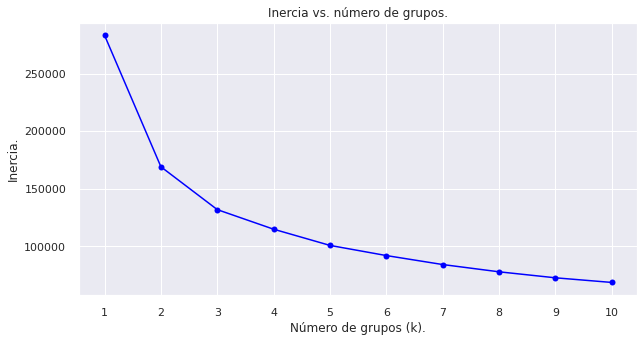

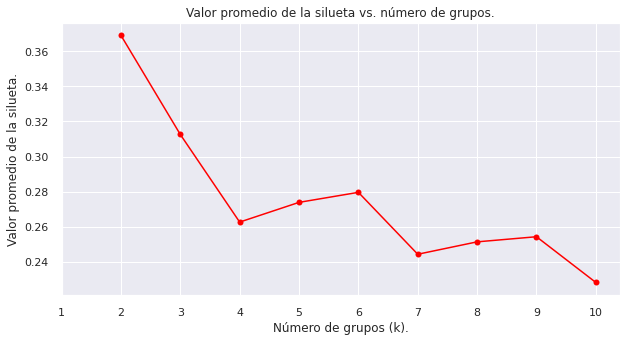

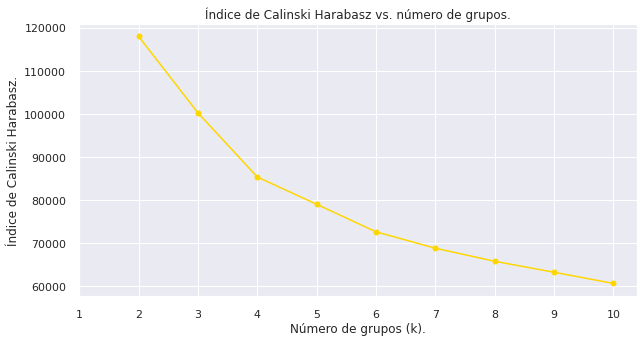

For k clusters = 2 The average silhouette_score is : 0.3691489160367881


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
elbow_calinski(genre_ratings_3, kmin, kmax, init, n_init, max_iter, random_seed)

## Model with 5 attributes and 4 groups

Centroides: [[2.99770886 2.97421658 2.97663936 2.96030092 2.96833201]
 [4.36957388 4.4196512  4.44368787 4.49801695 4.44638202]
 [3.8968478  3.91612217 3.93775925 3.96646592 3.92472613]
 [3.48412275 3.46743071 3.54441358 3.43091123 3.54740109]]


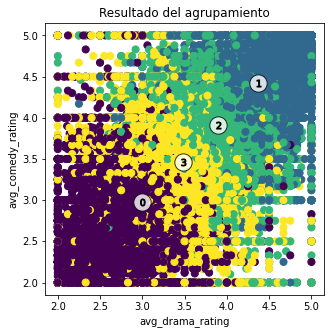

In [22]:
centroids = model(genre_ratings, 4, kmin, kmax, init, n_init, max_iter, random_seed)

In [23]:
centroids = pd.DataFrame(centroids, columns = ['Drama', 'Comedy', 'Thriller', 'Romance', 'Action'])
centroids

,Drama,Comedy,Thriller,Romance,Action
0,2.997709,2.974217,2.976639,2.960301,2.968332
1,4.369574,4.419651,4.443688,4.498017,4.446382
2,3.896848,3.916122,3.937759,3.966466,3.924726
3,3.484123,3.467431,3.544414,3.430911,3.547401


The groups are classified by same ratings of the different categories we proceed to reduce categories to 3

In [24]:
genre_ratings_3= get_genre_ratings(ratings_df, movies,
                                  [ 'Comedy', 'Romance', 'Action'],
                                  [ 'avg_comedy_rating', 'avg_romance_rating','avg_action_rating'])
print( "Number of records: ", len(genre_ratings_3))
print(genre_ratings_3.info())
genre_ratings_3.head()

Number of records:  252745
<class 'pandas.core.frame.DataFrame'>
Index: 252745 entries, 1 to 270882
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   avg_comedy_rating   230941 non-null  float64
 1   avg_romance_rating  200488 non-null  float64
 2   avg_action_rating   224521 non-null  float64
dtypes: float64(3)
memory usage: 7.7+ MB
None


,avg_comedy_rating,avg_romance_rating,avg_action_rating
1,4.25,4.5,3.50
2,2.80,4.0,3.67
3,3.25,3.5,3.00
4,2.80,3.5,3.67
5,5.00,5.0,2.67


In [25]:
#Remove less than 3 and  null values
#genre_ratings_3 = genre_ratings_3[genre_ratings_3>=4.0]
genre_ratings_3 = genre_ratings_3.dropna()
print(genre_ratings_3.info())

<class 'pandas.core.frame.DataFrame'>
Index: 174823 entries, 1 to 270896
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   avg_comedy_rating   174823 non-null  float64
 1   avg_romance_rating  174823 non-null  float64
 2   avg_action_rating   174823 non-null  float64
dtypes: float64(3)
memory usage: 5.3+ MB
None


Centroides: [[3.20582942 3.20497141 3.17138945]
 [4.3662519  4.46535407 4.2985023 ]
 [2.2151032  1.99475383 2.465     ]
 [3.75004692 3.74004263 3.83453559]]


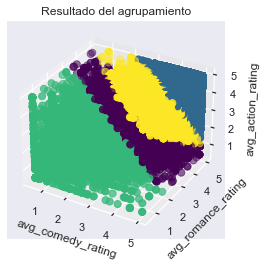

In [26]:
kmeans_4 = model_3d(genre_ratings_3, 4, kmin, kmax, init, n_init, max_iter, random_seed)

In [27]:
centroids_4 = pd.DataFrame(kmeans_4.cluster_centers_, columns = ['Comedy', 'Romance', 'Action'])
centroids_4

,Comedy,Romance,Action
0,3.205829,3.204971,3.171389
1,4.366252,4.465354,4.298502
2,2.215103,1.994754,2.465000
3,3.750047,3.740043,3.834536


Using the elbow we see that with four clusters the behaviour is similar to the previous model. We proceed to try with 6 clusters

Centroides: [[2.1354833  2.07052607 2.1552232 ]
 [3.88655331 4.23252062 2.78762257]
 [4.38628188 4.4744827  4.37547335]
 [3.77459166 3.76271478 3.89900108]
 [3.17128864 3.23425367 3.1878765 ]
 [3.17236347 2.5069258  4.01500886]]


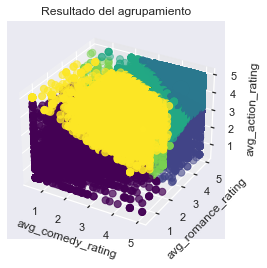

In [28]:
kmeans = model_3d(genre_ratings_3, 6, kmin, kmax, init, n_init, max_iter, random_seed)

In [29]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns = ['Comedy', 'Romance', 'Action'])
centroids

,Comedy,Romance,Action
0,2.135483,2.070526,2.155223
1,3.886553,4.232521,2.787623
2,4.386282,4.474483,4.375473
3,3.774592,3.762715,3.899001
4,3.171289,3.234254,3.187877
5,3.172363,2.506926,4.015009


Much better clusters are obtained as we can now establish some names for the categories such as:

0.   Don't like any (very low)
1.   Like Romance and comedy
2.   Like all of them (high)
3.   Like all of them (medium)
4.   Don't like any (low)
5.   Like Action



With this pattern we decide to merge groups 0-4 and groups 2-3 so we mantain the 4 groups suggested by the calinski elbow

In [30]:
#joining clusters
kmeans.cluster_centers_[0] = (kmeans.cluster_centers_[0]+kmeans.cluster_centers_[4])/2
kmeans.cluster_centers_[2] = (kmeans.cluster_centers_[2]+kmeans.cluster_centers_[3])/2
kmeans.cluster_centers_

array([[2.65338597, 2.65238987, 2.67154985],
       [3.88655331, 4.23252062, 2.78762257],
       [4.08043677, 4.11859874, 4.13723721],
       [3.77459166, 3.76271478, 3.89900108],
       [3.17128864, 3.23425367, 3.1878765 ],
       [3.17236347, 2.5069258 , 4.01500886]])

In [31]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns = ['Comedy', 'Romance', 'Action'])
centroids

,Comedy,Romance,Action
0,2.653386,2.652390,2.671550
1,3.886553,4.232521,2.787623
2,4.080437,4.118599,4.137237
3,3.774592,3.762715,3.899001
4,3.171289,3.234254,3.187877
5,3.172363,2.506926,4.015009


In [32]:
update_centroids = centroids.drop(3)
update_centroids = update_centroids.drop(4)
update_centroids

,Comedy,Romance,Action
0,2.653386,2.652390,2.671550
1,3.886553,4.232521,2.787623
2,4.080437,4.118599,4.137237
5,3.172363,2.506926,4.015009


In [33]:
#Format centroids back to original form
kmeans.cluster_centers_ = update_centroids.to_numpy()
kmeans.cluster_centers_ 

array([[2.65338597, 2.65238987, 2.67154985],
       [3.88655331, 4.23252062, 2.78762257],
       [4.08043677, 4.11859874, 4.13723721],
       [3.17236347, 2.5069258 , 4.01500886]])

In [34]:
#Update labels
kmeans.labels_[kmeans.labels_ == 4] = 0
kmeans.labels_[kmeans.labels_ == 3] = 2
kmeans.labels_

array([1, 0, 0, ..., 0, 2, 2])

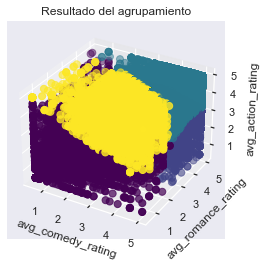

In [35]:
#New graph
sns.set(style = "darkgrid")
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
x = genre_ratings_3.iloc[:,0]
y = genre_ratings_3.iloc[:,1]
z = genre_ratings_3.iloc[:,2]

ax.set_xlabel(genre_ratings_3.columns[0]+'')
ax.set_ylabel(genre_ratings_3.columns[1]+'')
ax.set_zlabel(genre_ratings_3.columns[2]+'')

ax.scatter(x, y, z, c=kmeans.labels_.reshape((-1,1)), s=50, cmap='viridis')
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2], marker='o', color='white', edgecolor='k', s=300, alpha=0.8)

#Esto permite identificar cada centroide con su índice asociado. 
for i, c in enumerate(kmeans.cluster_centers_):
  ax.scatter(c[0], c[1], c[2], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')


plt.title('Resultado del agrupamiento')
plt.show()

After our transformation we can now see 4 groups:



0.   Purple: Users who don't like any movies
1.   Blue: Users who prefer romance and comedy movies
2.   Aqua: Users who like all movies
3.   Yellow: Users who prefer action movies





In [36]:
kmeans.get_params()

{'algorithm': 'lloyd',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 6,
 'n_init': 10,
 'random_state': 42,
 'tol': 0.0001,
 'verbose': 0}

In [37]:
#Test
values = np.array([[3.774592	,3.762715,	3.899001]])
#values = values.reshape(-1,1)
x = kmeans.predict(values)
x

c:\Users\Juan Pablo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


array([2])

In [58]:
unique, counts = np.unique(kmeans.labels_, return_counts=True)
count = dict(zip(unique, counts))
print(count)

{0: 49056, 1: 12840, 2: 101145, 5: 11782}


In [168]:
# Toy Story
# The Notebook
# Super Cool
# Jurassic Park
# Avatar 
user_movs = pd.DataFrame(columns=['movieId','original_title','genres'])
user_ratings = pd.DataFrame(columns=['userId','movieId','rating'])

i=movies[movies["original_title"]=="The Notebook"]
i2=movies[movies["original_title"]=="Avatar"]
i3=movies[movies["original_title"]=="Toy Story"]
if("Comedy" in str(i["genres"]) or "Action" in str(i["genres"]) or "Romance" in str(i["genres"])):
    for x in range(5):
        user_movs.loc[len(user_movs.index)] = i.values[0]
        user_ratings.loc[len(user_ratings.index)] = [1, i.values[0][0], 5]
   
    print(user_ratings)
elif(i.empty == False):
    print("Movie found but not in genres")
    print("Please add a movie of the genres Comedy, Romance or Action")
else:
    print("Movie not found")

genre_ratings_3= get_genre_ratings(user_ratings, user_movs, [ 'Comedy', 'Romance', 'Action'], [ 'avg_comedy_rating', 'avg_romance_rating','avg_action_rating'])
genre_ratings_3 = genre_ratings_3.fillna(2.5)
print(genre_ratings_3)
x = kmeans.predict(genre_ratings_3)
x1 = kmeans.transform(genre_ratings_3)
x1 = np.delete(x1, 0)
x2=sorted(range(len(x1)), key=lambda k: x1[k])
x2 = np.array(x2)
x2 = x2.astype('U256')
x2[x2=='2'] = "Action Packed"
x2[x2=='0'] = "Rom-Com"
x2[x2=='1'] = "All-Around"
print(x)
print(x1)
print(x2)

   userId  movieId  rating
0       1    11036       5
1       1    11036       5
2       1    11036       5
3       1    11036       5
4       1    11036       5
   avg_comedy_rating  avg_romance_rating  avg_action_rating
1                2.5                 5.0                2.5
[1]
[1.61067731 2.44032667 2.99378413]
['Rom-Commmm' 'All-Around' 'Action Packed']
